# Data Preprocessing

## Fetching Daily Data for the S&P 500 Components (Last 5 Years)

In this notebook, we prepare the dataset for volatility forecasting by fetching daily adjusted close prices for all S&P 500 constituents over the past 5 years using Yahoo Finance.

We clean and align the data across all tickers, compute log returns, and handle missing values to ensure consistency across time series.

Additionally, we explore long-term equilibrium relationships by performing pairwise cointegration tests across all ticker combinations. The results are summarized in a structured DataFrame containing p-values and a binary flag indicating whether the pairs are statistically cointegrated at a 5% significance level. This information can be leveraged later for feature engineering or portfolio construction.

In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
import time 
from tqdm import tqdm

In [14]:
# Fetch the S&P 500 stock data using PD HTML reader
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Extract tickers
tickers = pd.read_html(url)[0]['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]  # Corrected: replace on each ticker string

# Download the data
stock_data = yf.download(tickers, start='2019-01-01', end='2025-04-01', group_by='ticker', progress=False)


# Handle missing data
stock_data = stock_data.dropna(axis=1, thresh=(len(stock_data) * 0.9))  # Corrected: 'tresh' to 'thresh'
stock_data = stock_data.ffill()  # Forward fill missing data





1 Failed download:
['TSCO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2025-04-01)')


In [15]:
#Isolating the close columns from the MultiIndex

close = stock_data.loc[:, pd.IndexSlice[:, 'Close']] 
close.columns = close.columns.get_level_values(0)  # Flatten the MultiIndex

close.describe()  # Display the description of the DataFrame


Ticker,MOH,EQIX,ALLE,BKR,REGN,ARE,FTV,DHR,FITB,KIM,...,HES,UPS,AXON,CME,RVTY,AVY,LUV,AON,CTVA,K
count,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,...,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1471.000000,1570.000000
mean,257.338854,671.704159,110.828186,25.452381,642.168167,129.943822,66.984644,203.941164,29.208820,16.994739,...,96.118724,136.837374,185.284459,175.849983,121.579525,161.395736,38.685643,262.061662,45.393570,56.015464
std,81.523023,134.731453,16.166930,8.247714,207.724315,23.531921,8.237070,52.187267,8.228895,3.837119,...,40.736568,32.963240,137.026708,27.239476,28.615406,40.476858,9.580664,65.134032,12.991316,9.763708
min,105.900002,308.770386,73.616470,8.066182,273.109039,85.490845,34.433804,84.307533,9.438467,6.362993,...,26.950747,72.189682,43.290001,113.813446,65.961685,72.584457,21.466385,134.951126,19.494396,39.511993
25%,182.090004,602.914093,97.951002,19.490069,496.035072,112.441347,61.889789,170.281662,22.454251,14.555448,...,57.460565,102.178156,87.117500,156.922474,98.735569,119.397783,30.315529,197.741573,32.330090,50.440722
50%,283.555008,681.030151,108.974243,23.542417,629.520996,126.646759,67.190147,218.077972,30.006370,17.617501,...,89.854904,141.363937,150.560005,172.365059,118.309082,171.407097,36.159708,277.091919,47.380863,53.549286
75%,321.979996,760.753052,124.993816,31.941383,757.379181,143.538536,72.886793,242.578812,35.044290,19.556049,...,137.998741,164.038761,215.930000,193.989120,138.362854,195.607285,47.357649,313.258606,56.290482,59.219655
max,419.529999,979.904724,152.734238,48.613014,1200.217651,195.171219,85.929031,290.182556,47.562649,25.228037,...,162.811111,203.230118,710.010010,266.540009,199.591934,226.516495,60.581219,409.320007,65.971443,82.610001


In [16]:
#Calculating daily returns
log_returns  = np.log(close / close.shift(1)) * 100 

#Compute 10-day rolling volatility, annualized
realized_vol_10d = log_returns.rolling(window=10).std() * np.sqrt(252)  # Corrected: 'volatility' to 'std'

#Drop early NaN values 
log_returns = log_returns.dropna()
realized_vol_10d = realized_vol_10d.dropna()

log_returns.to_csv("/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/log_returns")
realized_vol_10d.to_csv("/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/realized_vol_10d")

print("✅ Log returns and realized volatility saved.")

✅ Log returns and realized volatility saved.


<Axes: title={'center': 'AAPL 10-Day Realized Volatility'}, xlabel='Date'>

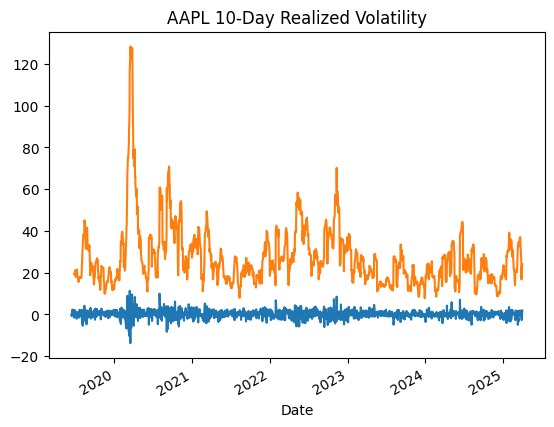

In [17]:
log_returns['AAPL'].plot(title='AAPL Log Returns')
realized_vol_10d['AAPL'].plot(title='AAPL 10-Day Realized Volatility')

In [18]:
#Compute average returns and volatility of all SP 500 stocks 
avg_returns = log_returns.mean()
avg_volatility = realized_vol_10d.mean()
avg_returns = avg_returns.sort_values(ascending=False)
avg_volatility = avg_volatility.sort_values(ascending=False)

# Compute the average return and volatility of all components together
overall_avg_return = avg_returns.mean()
overall_avg_volatility = avg_volatility.mean()

print(f"Overall Average Return: {overall_avg_return}")
print(f"Overall Average Volatility: {overall_avg_volatility}")

Overall Average Return: 0.04047290639852035
Overall Average Volatility: 29.907961823803483


## Explore Cointegration in the S&P 500 Stocks for Potential Pairs Trading Strategies

In addition to preparing the core data for forecasting, we also explore potential long-term statistical relationships between stocks through pairwise cointegration analysis. By testing all unique combinations of S&P 500 constituents, we identify pairs that are cointegrated at a 5% significance level — these may form the basis for future pairs trading strategies or act as features in volatility models. The results are compiled into a structured DataFrame with p-values and a boolean flag for cointegration.

In [19]:
from statsmodels.tsa.stattools import coint
from itertools import combinations

def cointegration_test(close_df, alpha=0.05):
    """
    Computes the Engle-Granger cointegration test for all unique pairs in a price DataFrame.

    Parameters:
    - close_df: pd.DataFrame with tickers as columns and datetime as index
    - alpha: significance level (default 0.05)

    Returns:
    - pd.DataFrame with columns: ['Ticker1', 'Ticker2', 'p-value', 'cointegrated']
    """
    results = []
    tickers = close_df.columns.tolist()

    for t1, t2 in tqdm(combinations(tickers, 2), total=int(len(tickers)*(len(tickers)-1)/2)):
        series1 = close_df[t1].dropna()
        series2 = close_df[t2].dropna()
        joined = pd.concat([series1, series2], axis=1).dropna()

        # Skip pairs with too few overlapping observations
        if len(joined) < 100:
            continue

        try:
            score, pvalue, _ = coint(joined[t1], joined[t2])
            results.append({
                'Ticker1': t1,
                'Ticker2': t2,
                'p-value': pvalue,
                'cointegrated': pvalue < alpha
            })
        except Exception as e:
            print(f"⚠️ Error with pair {t1}-{t2}: {e}")
            continue

    return pd.DataFrame(results).sort_values(by='p-value')

In [ ]:
cointegration_results = cointegration_test(close, alpha=0.05)

In [ ]:
# Save the results to a CSV file
cointegration_results.to_csv("/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/cointegration_results.csv", index=False)
print(" Cointegration results saved.")

# Display the first few rows of the results
cointegration_results.head()

# Display the number of cointegrated pairs
num_cointegrated_pairs = cointegration_results['cointegrated'].sum()
print(f"Number of cointegrated pairs: {num_cointegrated_pairs}")

# Display the number of non-cointegrated pairs
num_non_cointegrated_pairs = (~cointegration_results['cointegrated']).sum()

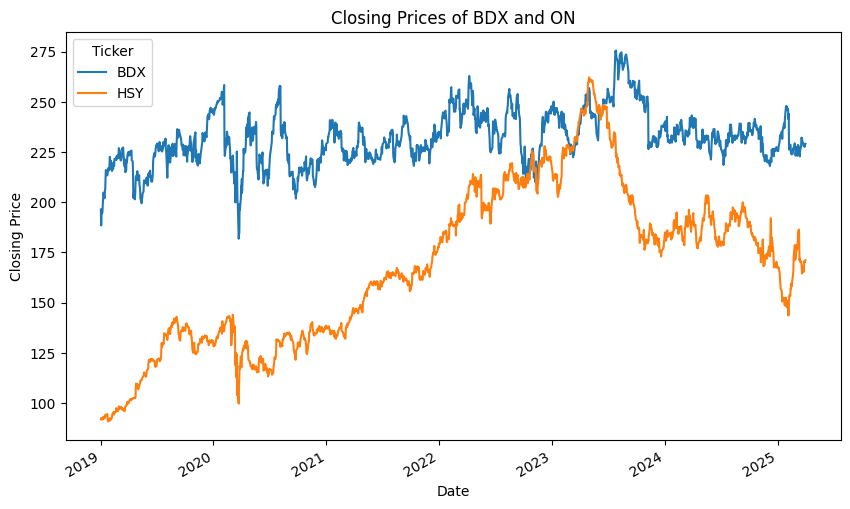

In [ ]:
# Plot the closing prices of two cointegrated stocks

close[['BDX', 'HSY']].plot(title='Closing Prices of BDX and ON', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Ticker')
plt.show()

In [ ]:
#Clean up the cointegration results
file_path = "/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/cointegration_results.csv"
cointegration_results = pd.read_csv(file_path)

# Make sure the 'cointegrated' column is boolean
cointegration_results['cointegrated'] = cointegration_results['cointegrated'].astype(str).str.lower() == 'true'

# Filter for cointegrated pairs only
cointegrated_pairs = cointegration_results[cointegration_results['cointegrated']]

# Preview
print(cointegrated_pairs.head())

#Export the cointegrated pairs to a CSV file
cointegrated_pairs.to_csv("/Users/nodisionut/Desktop/PYTHON WORKHOURSE/volatility-forecasting-hybrid-models/volatility-forecasting-hybrid-models/data/cointegrated_pairs.csv", index=False)

  Ticker1 Ticker2   p-value  cointegrated
0     BDX      ON  0.000007          True
1    AMAT    NXPI  0.000008          True
2    DECK     URI  0.000011          True
3    DECK     ETN  0.000013          True
4     WAB    AVGO  0.000014          True
